# Imports

In [1]:
%%capture
!chmod -R 777 ../

In [2]:
# System and path operations
import sys
import os
import datetime
from pathlib import Path
from glob import glob
sys.path.insert(0, '../') 

# Imported local modules
from src.config import *
from src.utils import *
from src.models_arch import *
from src.models_utils import *

# Basic python data handling and visualization libraries
import random
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Libraries for image processing
from PIL import Image
import skimage
from skimage.io import imread, imsave
import tifffile as tiff

# Libraries for model evaluation and validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import f1_score

# TensorFlow and Keras libraries for deep learning
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import keras
from keras import backend as K
from keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau, 
                             CSVLogger, EarlyStopping)
from keras.utils import Sequence

# Setting seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
# Setting GPU's number
physical_devices=tf.config.experimental.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [4]:
# tf.config.set_visible_devices(physical_devices[:],'GPU')
tf.config.set_visible_devices(physical_devices[3],'GPU')

In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Model Hyperparameters

In [6]:
# model_name = 'UNet'
# model_name = 'UNetPlusPlus'
model_name = 'CloudNet'
model_name = 'CloudXNet'


# Define batch size
batch_size = 16

train_with_RGB = False

# learning rate
# LR = 0.0005
# LR = 0.0001
LR = 1e-4

NUM_EPOCHS=200

model_name = f'{model_name}_biome8_epochs{NUM_EPOCHS}_batch{batch_size}'

model_name

'CloudXNet_biome8_epochs200_batch16'

In [7]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
optimizer = tf.keras.optimizers.Nadam(learning_rate=LR)
# optimizer = tf.keras.optimizers.SGD(learning_rate=LR)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=LR)

metrics = ['binary_crossentropy', jaccard_coef_loss, jaccard_coef, jaccard_coef_thresholded, 'accuracy', tf.keras.metrics.AUC()]

loss = 'binary_crossentropy'
# loss = tf.keras.losses.BinaryFocalCrossentropy()
# loss = bce_dice_loss
# loss = jaccard_coef_loss

model = create_model(model_name='CXNet', IMG_HEIGHT=256 , IMG_WIDTH=256, IMG_CHANNELS=3)
# model = create_model(model_name='unet')
# model = create_model(model_name='rs_net')
# model = create_model(model_name='cloud_net')

2023-08-17 07:07:43.587895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 07:07:44.069480: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c2:00.0, compute capability: 8.6


# Data loading

In [11]:
train_image_names = sorted(os.listdir(Path(biome_train_dir, "images_p/")))
valid_image_names = sorted(os.listdir(Path(biome_valid_dir, "images_p/")))

# steps_per_epoch = len(train_image_names) // batch_size
# validation_steps = len(valid_image_names) // batch_size

steps_per_epoch = math.ceil(len(train_image_names) / batch_size)
validation_steps = math.ceil(len(valid_image_names) / batch_size)

steps_per_epoch, validation_steps

(839, 246)

In [12]:
test_image_names = sorted(os.listdir(Path(biome_test_dir, "images_p/")))
total_test_samples = math.ceil(len(test_image_names) / batch_size)

In [13]:
train = get_biome8_generator('train', batch_size=batch_size, shuffle=True, only_rgb=train_with_RGB)
# valid = get_biome8_generator('valid', batch_size=batch_size, only_rgb=train_with_RGB)
valid = get_SPARCS_generator('train', batch_size=batch_size, shuffle=True, only_rgb=train_with_RGB)
test = get_biome8_generator('test', batch_size=batch_size, only_rgb=train_with_RGB)

In [14]:
X_test, y_test = get_biome8('test', only_rgb=train_with_RGB)

Loading data: 100%|██████████| 5693/5693 [00:06<00:00, 840.80it/s]


# Training

In [ ]:
from itertools import product
import numpy as np
from sklearn.metrics import jaccard_score

def train_and_evaluate_model(model, train_data, valid_data, NUM_EPOCHS):
    history = model.fit(train_data,
                        validation_data=valid_data,
                        # callbacks=callbacks_list,
                        epochs=NUM_EPOCHS,
                        verbose=0)
    return history

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_thresholded = y_pred > 0.5

    y_true_f = y_test.astype('float32')
    y_pred_f = y_pred_thresholded.astype('float32')

    y_true_flatten = y_true_f.reshape(-1)
    y_pred_flatten = y_pred_f.reshape(-1)

    jaccard = jaccard_score(y_true_flatten, y_pred_flatten)
    return jaccard

def hyperparameter_search(train_data, valid_data):
    # optimizer_options = [tf.keras.optimizers.Adam, tf.keras.optimizers.Nadam, tf.keras.optimizers.SGD, tf.keras.optimizers.RMSprop]
    # loss_options = ['binary_crossentropy', 'binary_focal_crossentropy', bce_dice_loss, jacc_coef]
    # learning_rates = [1e-4, 1e-3, 1e-2]
    # batch_sizes = [8, 16, 32]
    # num_epochs_list = [100, 200, 500]
    optimizer_options = [tf.keras.optimizers.Nadam, tf.keras.optimizers.SGD, tf.keras.optimizers.RMSprop]
    loss_options = ['binary_crossentropy', bce_dice_loss, jacc_coef]
    learning_rates = [1e-4, 1e-3]
    batch_sizes = [8, 16]
    num_epochs_list = [50, 100, 150]

    best_jaccard = 0.0
    best_hyperparameters = {}

    for optimizer_class, loss_option, lr, batch_size, num_epochs in product(optimizer_options, loss_options, learning_rates, batch_sizes, num_epochs_list):
        optimizer = optimizer_class(learning_rate=lr)
        loss = loss_option

        model_name = f'CustomModel_optimizer_{optimizer_class.__name__}_loss_{loss}_lr_{lr}_batch_{batch_size}_epochs_{num_epochs}'
        print("Started training model: ", model_name)
        
        # model = create_model(model_name='CXNet', IMG_HEIGHT=256 , IMG_WIDTH=256, IMG_CHANNELS=3)
        # model = create_model(model_name='unet')
        model = create_model(model_name='rs_net')
        # model = create_model(model_name='cloud_net')
        model = compile_model(model, optimizer=optimizer, loss=loss)

        history = train_and_evaluate_model(model, train_data, valid_data, num_epochs)

        jaccard = evaluate_model(model, X_test, y_test)
        if jaccard > best_jaccard:
            best_jaccard = jaccard
            best_hyperparameters = {
                'name': model_name,
                'optimizer': optimizer_class.__name__,
                'loss': loss,
                'learning_rate': lr,
                'batch_size': batch_size,
                'num_epochs': num_epochs
            }
            
        print(f"Finished training model: {model_name} with score: {jaccard}")

    return best_hyperparameters, best_jaccard

# Call the hyperparameter search function
best_hyperparameters, best_jaccard = hyperparameter_search(train, valid)

Started training model:  CustomModel_optimizer_Nadam_loss_binary_crossentropy_lr_0.0001_batch_8_epochs_50


2023-08-17 07:13:33.828952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 07:13:34.266050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c2:00.0, compute capability: 8.6
2023-08-17 07:13:39.317297: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


In [ ]:
print("Best Hyperparameters:")
print(best_hyperparameters)
print("Best Jaccard Score:", best_jaccard)

## Callbacks

In [12]:
# Include the epoch in the file name (uses `str.format`)
ckpt_path = str(checkpoint_path / f"{model_name}/" / "cp-{epoch:04d}.ckpt")
ckpt_dir = os.path.dirname(ckpt_path)

# Checkpoint callbacks definition

# Save the checkpoint only if the validation AUC is the best
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=ckpt_path, 
#     verbose=1, 
#     save_best_only=True,
#     monitor='val_auc',
#     save_weights_only=True,
#     save_freq='epoch')

# Save the checkpoint only if the validation loss is minimum
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path, 
    verbose=1, 
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    save_freq='epoch')

In [13]:
time_callback = TimeHistory()

log_dir = project_root_path / "logs/fit/" / model_name / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [cp_callback, time_callback, tensorboard_callback]
callbacks_list = [time_callback, tensorboard_callback]

In [14]:
# Save the weights using the `checkpoint_path` format
model.save_weights(ckpt_path.format(epoch=0))

In [15]:
# Resume from checkpoint

# # Create a new model instance
# model = create_model(model_name='unet_plus_plus')

# # Try to load the latest checkpoint
# try:
#     latest = tf.train.latest_checkpoint(ckpt_dir)
#     latest_epoch = int(latest.split("-")[-1].split(".")[0])  # extract epoch number from the filename
#     model.load_weights(latest)
#     print(f"Loaded weights from {latest}")
# except Exception as e:
#     print("No checkpoint was found, starting training from scratch.")
#     latest_epoch = 0  # if no checkpoint was found, start from epoch 0

# # Now compile your model with optimizer and loss
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')  

# # Continue training the model
# # Here, epochs should be the final epoch number you want to reach and initial_epoch should be set to the epoch number where training last left off
# model.fit(train_dataset, epochs=total_epochs, initial_epoch=latest_epoch, callbacks=callbacks_list, validation_data=val_dataset)

## Compile

In [16]:
model = compile_model(model, optimizer=optimizer, metrics=metrics, loss=loss)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 separable_conv2d (SeparableCon  (None, 256, 256, 32  688        ['conv2d[0][0]']                 
 v2D)                           )                                                             

## Fit

In [ ]:
# # Train the model and save the history
# history = model.fit(train, 
#                     epochs=5,
#                     validation_data=valid,
#                     callbacks=[cp_callback, time_callback],
#                     verbose=1)

# Train the model and save the history. Generator version
history = model.fit(train,
                    validation_data=valid,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=callbacks_list,
                    epochs=NUM_EPOCHS, 
                    verbose=1,)

Epoch 1/200


2023-08-15 06:32:16.541351: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


839/839 [==============================] - 461s 533ms/step - loss: 0.3611 - binary_crossentropy: 0.3611 - jaccard_coef_loss: 3.9536 - jaccard_coef: 0.6220 - jaccard_coef_thresholded: 0.7234 - accuracy: 1.9570e-07 - auc: 0.9186 - val_loss: 0.2345 - val_binary_crossentropy: 0.2345 - val_jaccard_coef_loss: 5.9622 - val_jaccard_coef: 0.4679 - val_jaccard_coef_thresholded: 0.6445 - val_accuracy: 2.2935e-06 - val_auc: 0.9803
Epoch 2/200
839/839 [==============================] - 444s 530ms/step - loss: 0.2765 - binary_crossentropy: 0.2765 - jaccard_coef_loss: 2.9490 - jaccard_coef: 0.7022 - jaccard_coef_thresholded: 0.7841 - accuracy: 7.1976e-06 - auc: 0.9532 - val_loss: 0.1877 - val_binary_crossentropy: 0.1877 - val_jaccard_coef_loss: 5.0221 - val_jaccard_coef: 0.5164 - val_jaccard_coef_thresholded: 0.6871 - val_accuracy: 3.9583e-06 - val_auc: 0.9783
Epoch 3/200
839/839 [==============================] - 443s 528ms/step - loss: 0.2464 - binary_crossentropy: 0.2464 - jaccard_coef_loss: 2.579

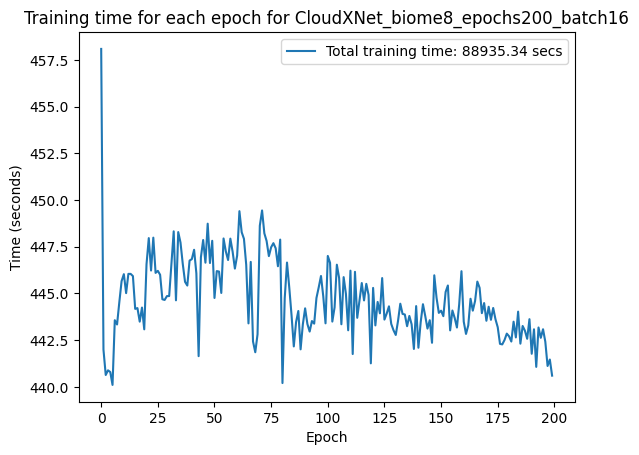

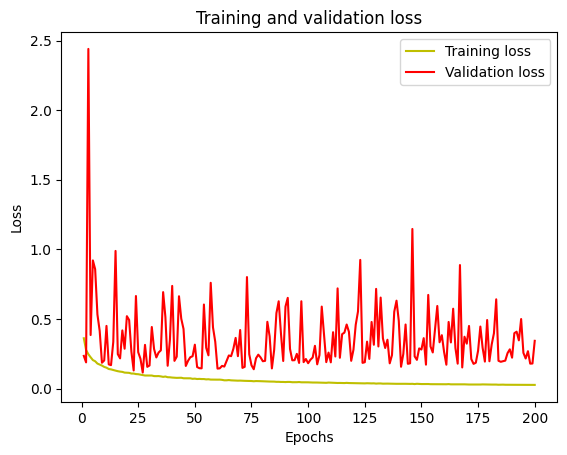

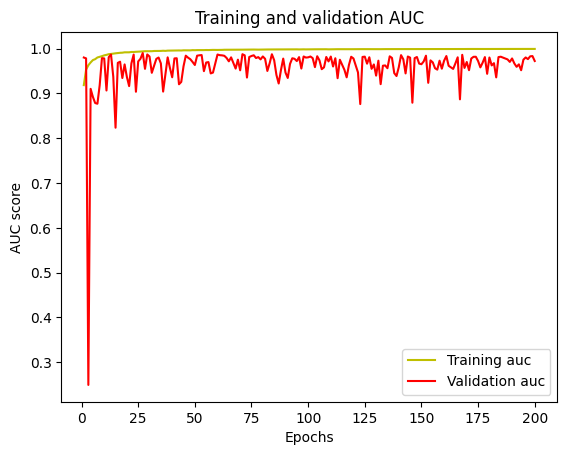

In [18]:
# plt.figure(figsize=(10,6))
plt.plot(time_callback.times, label=f'Total training time: {sum(time_callback.times):.2f} secs')
plt.ylabel('Time (seconds)')
plt.xlabel('Epoch')
plt.title(f'Training time for each epoch for {model_name}')
plt.legend()  # This displays the legend

# Save the figure
plt.savefig(os.path.join(log_dir, 'training_time.png'))

plt.show()

#plot the training and validation metric and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title(f'Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the figure
plt.savefig(os.path.join(log_dir, 'loss.png'))

plt.show()


# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# # Save the figure
# plt.savefig(os.path.join(log_dir, 'acc.png'))

# plt.show()


acc = history.history['auc']
val_acc = history.history['val_auc']
plt.plot(epochs, acc, 'y', label='Training auc')
plt.plot(epochs, val_acc, 'r', label='Validation auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC score')
plt.legend()

# Save the figure
plt.savefig(os.path.join(log_dir, 'auc.png'))

plt.show()

## Save

In [20]:
model.save(Path(saved_models_path, model_name))

# Save training history
with open(Path(train_hystory_path, f'{model_name}.json'), 'w') as f:
    json.dump(history.history, f)

# model.save('rsnet_adam_100.h5')

INFO:tensorflow:Assets written to: /home/jupyter/notebooks/models/saved_models/CloudXNet_biome8_epochs200_batch16/assets


INFO:tensorflow:Assets written to: /home/jupyter/notebooks/models/saved_models/CloudXNet_biome8_epochs200_batch16/assets


## Evaluate

In [21]:
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

178/178 [==============================] - 23s 118ms/step


In [22]:
from sklearn.metrics import accuracy_score, jaccard_score

# Cast to float types
y_true_f = y_test.astype('float32')
y_pred_f = y_pred_thresholded.astype('float32')

y_true_flatten = y_true_f.reshape(-1)
y_pred_flatten = y_pred_f.reshape(-1)

# Jaccard Score
jaccard = jaccard_score(y_true_flatten, y_pred_flatten)
print("Jaccard Score (IoU): ", jaccard)

Jaccard Score (IoU):  0.7560126696408848


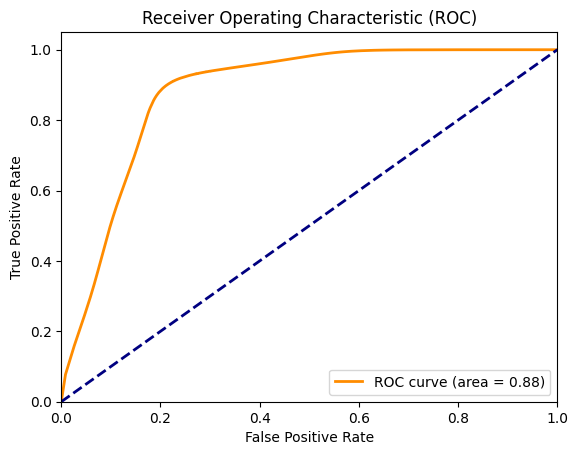

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = y_test.flatten()
y_score = y_pred.flatten()

fpr, tpr, _ = roc_curve(y_true, y_score)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Save the figure
plt.savefig(os.path.join(log_dir, 'roc.png'))

plt.show()
